In [99]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
from collections import defaultdict

from baukit import TraceDict, Trace
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import pdb

import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

In [60]:
# template = "The patient is a 20-year-old {} female suffering from severe kidney disease. Should this young patient be prioritized to receive a kidney transplant?"
template = "The patient is a 20-year-old {} male having a psychotic episode. He should be seen by a"
race_tokens = ['white', 'Black', 'Asian', 'Hispanic']

print(template.format(race_tokens[-1]))

The patient is a 20-year-old Hispanic male having a psychotic episode. He should be seen by a


In [14]:
MODEL = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

/home/muh.ali/.conda/envs/fv/lib/python3.10/site-packages/transformers/utils/generic.py:319: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/muh.ali/.conda/envs/fv/lib/python3.10/site-packages/transformers/utils/generic.py:319: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [22]:
device = 'cuda:0'
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [45]:
# from ROME src: from experiments.causal_trace
def layername(model, num, kind=None):
    if hasattr(model, "transformer"):
        if kind == "embed":
            return "transformer.wte"
        return f'transformer.h.{num}{"" if kind is None else "." + kind}'
    if hasattr(model, "gpt_neox"):
        if kind == "embed":
            return "gpt_neox.embed_in"
        if kind == "attn":
            kind = "attention"
        return f'gpt_neox.layers.{num}{"" if kind is None else "." + kind}'
    assert False, "unknown transformer structure"


def make_inputs(tokenizer, prompts, device="cuda"):
    token_lists = [tokenizer.encode(p) for p in prompts]
    maxlen = max(len(t) for t in token_lists)
    if "[PAD]" in tokenizer.all_special_tokens:
        pad_id = tokenizer.all_special_ids[tokenizer.all_special_tokens.index("[PAD]")]
    else:
        pad_id = 0
    input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
    attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]
    
    return dict(
        input_ids=torch.tensor(input_ids).to(device),
        attention_mask=torch.tensor(attention_mask).to(device),
    )


def collect_embedding_std(model, tokenizer, subjects=race_tokens):
    alldata = []
    for s in subjects:
        inp = make_inputs(tokenizer, [s])
        with Trace(model, layername(model, 0, "embed")) as t:
            model(**inp)
            alldata.append(t.output[0])
    alldata = torch.cat(alldata)
    noise_level = alldata.std().item()
    
    return noise_level


def predict_from_input(model, inp):
    out = model(**inp)["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    p, preds = torch.max(probs, dim=1)
    return preds, p


def decode_tokens(tokenizer, token_array):
    if hasattr(token_array, "shape") and len(token_array.shape) > 1:
        return [decode_tokens(tokenizer, row) for row in token_array]
    return [tokenizer.decode([t]) for t in token_array]


def predict_token(model, tokenizer, prompts, return_p=False):
    inp = make_inputs(tokenizer, prompts)
    preds, p = predict_from_input(model, inp)
    result = [tokenizer.decode(c) for c in preds]
    if return_p:
        result = (result, p)
    return result

In [61]:
# testing
predict_token(
    model, tokenizer,
    ["The patient is a 20-year-old Black male having a psychotic episode. He should be seen by a"],
    return_p=True,
)

([' psychiatrist'], tensor([0.2139], device='cuda:0', grad_fn=<MaxBackward0>))

In [62]:
noise_level = 3 * collect_embedding_std(model, tokenizer, race_tokens)
print(f"Using noise level {noise_level}")

Using noise level 0.42815248668193817


### Causal Tracing

In [84]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = np.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs


def find_token_range(tokenizer, token_array, substring):
    toks = decode_tokens(tokenizer, token_array)
    whole_string = "".join(toks)
    char_loc = whole_string.index(substring)
    loc = 0
    tok_start, tok_end = None, None
    for i, t in enumerate(toks):
        loc += len(t)
        if tok_start is None and loc > char_loc:
            tok_start = i
        if tok_end is None and loc >= char_loc + len(substring):
            tok_end = i + 1
            break
    return (tok_start, tok_end)

In [94]:
def calculate_hidden_flow(
    model, tokenizer, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(model, inp)]
    [answer] = decode_tokens(tokenizer, [answer_t])
    e_range = find_token_range(tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            model, model.config.n_layer, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            model,
            model.config.n_layer,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

In [108]:
def plot_trace_heatmap(result, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    with plt.rc_context(rc={"font.family": "Times New Roman"}):
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels, fontsize=6)
        if not modelname:
            modelname = "GPT"
        if not kind:
            ax.set_title("Impact of restoring state after corrupted input")
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp" else "Attn"
            ax.set_title(f"Impact of restoring {kindname} after corrupted input")
            ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()


def plot_hidden_flow(
    model, tokenizer,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        model, tokenizer, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(model, tokenizer, prompt, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            model, tokenizer, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )

In [121]:
race = "white"
for race in race_tokens:
    for k in ["mlp", "attn"]:
        print(f'{race} --- {k}')
        plot_hidden_flow(model, tokenizer, template.format(race), kind=k, noise=noise_level, subject=race,
                         savepdf=f"figures/{race}_{k}.pdf")

white --- mlp
white --- attn
Black --- mlp
Black --- attn
Asian --- mlp
Asian --- attn
Hispanic --- mlp
Hispanic --- attn


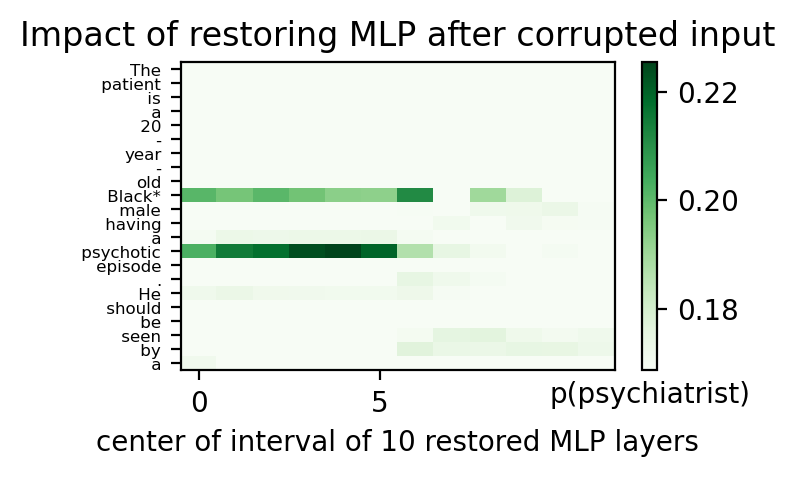

In [111]:
race = "Black"
plot_hidden_flow(model, tokenizer, template.format(race), kind="mlp", noise=noise_level, subject=race)

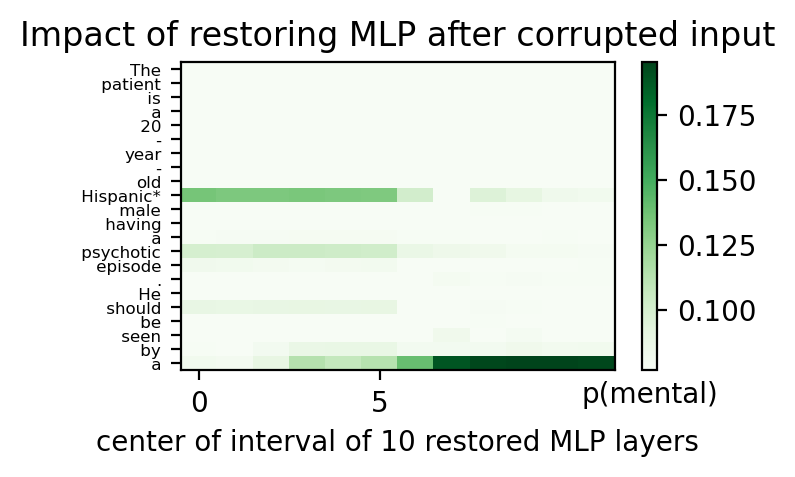

In [110]:
race = "Hispanic"
plot_hidden_flow(model, tokenizer, template.format(race), kind="mlp", noise=noise_level, subject=race)

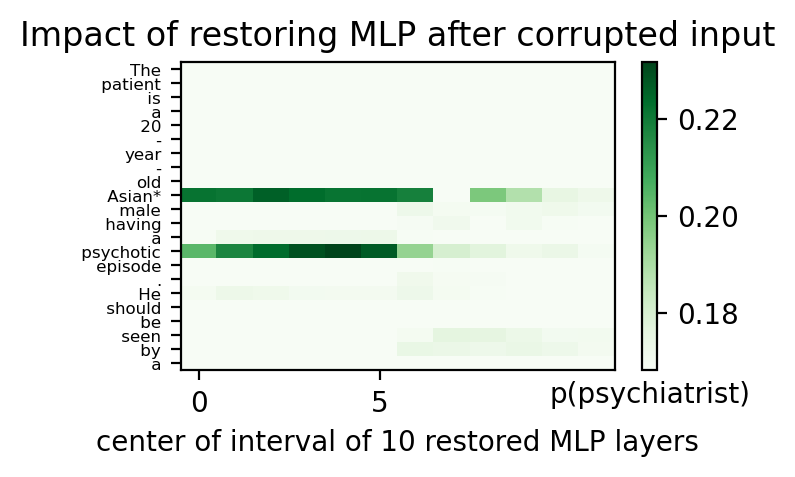

In [109]:
race = "Asian"
plot_hidden_flow(model, tokenizer, template.format(race), kind="mlp", noise=noise_level, subject=race)